In [1]:
from itertools import combinations
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.datasets import make_moons, make_blobs, make_circles, make_classification, make_gaussian_quantiles
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.python.ops import math_ops

# Add parent directory to path to 
# allow imports of custom modules
if not '..' in sys.path:
    sys.path.append('..')
    
from models.losses import SimilarityLoss
from utils.generic import progress_bar

In [2]:
PROJECT_HOME = '../../'
VIS_PATH = PROJECT_HOME+'vis/'

In [3]:
def get_two_class_data(shape, n=100, std=0.05, seed=None):    
    if shape=='moons':
        return make_moons(n_samples=n, noise=std, random_state=seed)
    elif shape=='circles':
        return make_circles(n_samples=n, noise=std, random_state=seed)
    else:
        raise ValueError("Shape must be either 'moons' or 'circles'")

def get_multi_class_data(shape, n_classes=3, n_samples=100, seed=None):
    if shape=='normal':
        return make_classification(n_samples=n_samples,
                                   n_features=8, 
                                   n_informative=4,
                                   n_redundant=2, 
                                   n_clusters_per_class=1, 
                                   n_classes=n_classes,
                                   random_state=seed)
    if shape=='quantiles':
        return make_gaussian_quantiles(n_samples=n_samples,
                                       n_classes=n_classes,
                                       random_state=seed)
        
#X, y = get_multi_class_data('normal', n_samples=1000, n_classes=3)
X, y = get_two_class_data('circles', n=400, std=0.01)
X, X_t, y, y_t = train_test_split(X, y, test_size=0.2, random_state=133)
X.shape

(320, 2)

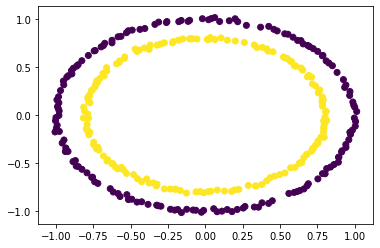

In [4]:
plt.scatter(X[:,0], X[:,1], c=y)

## Possible approaches

1. Use a label $R_{t}$ that'll be used in the loss
    - Problem: what is $R_{t}$ for classes? Metric in input space is uninformative
2. Always feed two examples of one class, and counter example of different class

We will start with **approach 2**: Each element in `data` will contain 3 elements, each of which is a coordinate represented as 2-D array. The first 2 elements belong to the same class, while the last element is of a different class.

In [5]:
# In the dataset, one datapoint should be a triplet of tuples representing coordinates
def createTripletData(X, y):
    data = []
    # for each class
    labels = np.unique(y)
    for label in labels:
        print('Label', label)
        elems = X[np.argwhere(y==label)][:,0,:][:50]
        # for all combinations of elems in that class
        for xi, xj in combinations(elems, 2):
            # combine with every element from other class(es)
            for cont_elem in X[np.argwhere(y!=label)][:,0,:]:
                data.append([xi, xj, cont_elem])
    
    print('Created triplets.')            
    # some additional processing
    print('Casting to numpy array ...')
    data = np.array(data)
    print('Shuffling ...')
    np.random.shuffle(data)
    print('Transposing axis 0 and 1 ...')
    data = np.transpose(data, (1,0,2))
    print('Done.')
    return data

data = createTripletData(X, y)
data.shape

Label 0
Label 1
Created triplets.
Casting to numpy array ...
Shuffling ...
Transposing axis 0 and 1 ...
Done.


(3, 392000, 2)

## Create Model

In [6]:
n_in_nodes = X.shape[1]
n_out_nodes = 2
n_hidden = 8

def create_base_network(inp_shape):
    inp = keras.Input(shape=inp_shape)
    hidden = layers.Dense(n_hidden, 'relu')(inp)
    out = layers.Dense(n_out_nodes, 'linear')(hidden)
    return keras.Model(inp, out)

emb = create_base_network(inp_shape=n_in_nodes) # output_shape : (None, 2)

ins = [keras.Input(shape=n_in_nodes, name=str(i)) for i in range(3)]
x = [emb(ins[i]) for i in range(3)]
x = layers.Concatenate()(x) # (None, 6)
x = layers.Reshape((3,n_out_nodes))(x) # (None, 3, 2)

model = keras.Model(ins, x)
print(model.input_shape, model.output_shape)
# Input shape : (3, None, 2)
# Output shape : (None, 3, 2)

[(None, 2), (None, 2), (None, 2)] (None, 3, 2)


In [7]:
similarity_loss = SimilarityLoss(gamma=1, beta=0.5, alpha=1)
optimizer = tf.keras.optimizers.Adam()
loss_history = []

In [8]:
bs = 64

def train_step(batch):
    with tf.GradientTape() as tape:
        logits = model(batch, training=True)
        # Add asserts to check the shape of the output.
        #tf.debugging.assert_equal(logits.shape, (n, 6))
        loss_value = similarity_loss(logits)
        mean_loss = loss_value.numpy().mean()
    loss_history.append(mean_loss)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return mean_loss

def train(epochs, steps_per_epoch=None):
    
    if steps_per_epoch:
        max_steps = steps_per_epoch
    else:
        max_steps = len(data[0])//bs
    
    for epoch in range(1,epochs+1):
        print('Epoch {}'.format(epoch))

        step = 0
        for i in range(0, len(data[0]), bs):
            batch = [data[0,i:i+bs,:],data[1,i:i+bs,:],data[2,i:i+bs,:]]
            loss_value = train_step(batch)
            step += 1
            
            if step % 100 == 0:
                print('{} batch {}/{} | loss: {:.6f} \r'
                      .format(progress_bar(step/max_steps), 
                              step, 
                              max_steps,
                              float(loss_value)), 
                      end='')
            if step % max_steps == 0:
                break
                
        print('\n')
                
train(1, steps_per_epoch=5000)

Epoch 1
[=========================] batch 5000/5000 | loss: 0.008833 



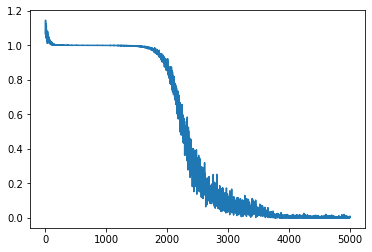

In [9]:
plt.plot(loss_history)
#plt.savefig(VIS_PATH+'2_feat_1_out_8_hidden_losshistory')

## Check learned representations

In [10]:
def get_projection(dp):
    return list(emb(np.array([dp])).numpy()[0])
    #return list(model([np.array([dp]),np.array([[0]*n_in_nodes]),np.array([[0]*n_in_nodes])]).numpy()[0,0])

# Test on unseen data
Y_Hat = np.array([get_projection(dp) for dp in X])

if n_out_nodes == 1:
    axarr = np.array([[0.]]*Y_Hat.shape[0])
    Y_Hat = np.concatenate((Y_Hat, axarr), axis = 1)
    print('Extended 1-D projections for plotting.')

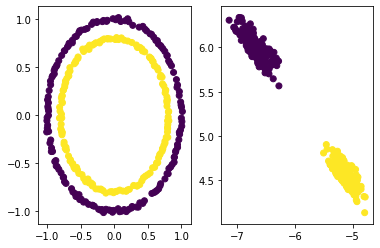

In [11]:
fig, ax = plt.subplots(1,2)
#ax[0].axis('off')
ax[0].scatter(X[:,0], X[:,1], c=y)
#ax[1].axis('off')
ax[1].scatter(Y_Hat[:,0], Y_Hat[:,1], c=y)
#plt.savefig(VIS_PATH+'8_feat_3_out_8_hidden')
plt.show()

## Linear classifier on last layer

Building models ...
Fitting pre-trained model ...
Fitting random model ...


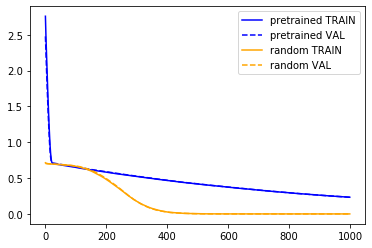

10/10 [==============================] - 0s 753us/step - loss: 5.1781e-08


(0.23193936049938202, 5.178146622597524e-08)

In [30]:
def test_linear_clf(embnet, X, y, X_t, y_t):

    print('Building models ...')
       
    # Extend embedding network with linear classification layer
    x = embnet.output
    x = layers.Dense(len(np.unique(y)), 'softmax', name='linear_classifier')(x)
    linear_model = keras.Model(inputs=embnet.input, outputs=x)
    # Fix weights of all embedding layers, only leave classifier
    for i in range(3):
        linear_model.layers[i].trainable = False
    # Compile with cross entropy loss for classification
    linear_model.compile(loss=tf.keras.losses.CategoricalCrossentropy())

    # Build randomly initialized model for comparison
    inp = keras.Input(shape=embnet.input_shape[-1])
    x = layers.Dense(embnet.layers[1].output_shape[-1], 'relu')(inp)
    x = layers.Dense(n_out_nodes, 'linear')(x)
    x = layers.Dense(len(np.unique(y)), 'softmax', name='linear_classifier')(x)
    rand_model = keras.Model(inp, x)
    # Compile with cross entropy loss for classification
    rand_model.compile(loss=tf.keras.losses.CategoricalCrossentropy())
 
    # Make y-vector one hot
    y_onehot = tf.one_hot(y, depth=len(np.unique(y)))
    y_t_onehot = tf.one_hot(y_t, depth=len(np.unique(y)))
    
    # Fit the models
    epochs=1000
    print('Fitting pre-trained model ...')
    history1 = linear_model.fit(X, y_onehot, verbose=0, epochs=epochs,
                              validation_data=(X_t,y_t_onehot))
    print('Fitting random model ...')
    history2 = rand_model.fit(X, y_onehot, verbose=0, epochs=epochs,
                              validation_data=(X_t,y_t_onehot))
    
    # Plot the training histories, skipping first 100 epochs
    skip = 0
    plt.plot(history1.history['loss'][skip:], label='pretrained TRAIN', c='b')
    plt.plot(history1.history['val_loss'][skip:], label='pretrained VAL', c='b', ls='--')
    plt.plot(history2.history['loss'][skip:], label='random TRAIN', c='orange')
    plt.plot(history2.history['val_loss'][skip:], label='random VAL', c='orange', ls='--')
    plt.legend()
    plt.show()
    
    # Return evaluation score
    return (linear_model.evaluate(X,y_onehot), rand_model.evaluate(X,y_onehot))

test_linear_clf(emb, X, y, X_t, y_t)

In [27]:
from sklearn.svm import LinearSVC

In [28]:
svc = LinearSVC(max_iter=5000)
svc.fit(Y_Hat, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

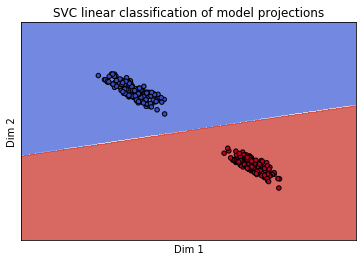

In [29]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

C = 1.0  # SVM regularization parameter

X0, X1 = Y_Hat[:, 0], Y_Hat[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots(1,1)
plot_contours(ax, svc, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('SVC linear classification of model projections')

plt.show()